# Kalman filter example

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rebayes.linear_filter import kf

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

In [3]:
y = jnp.array([2.4865, -0.3033, -4.0531, -4.3359, -6.1742, -5.604, -3.5069, -2.3257, -4.6377,
               -0.2327, -1.9858, 1.0284, -2.264, -0.4508, 1.1672, 6.6524, 4.1452, 5.2677, 6.3403, 9.6264, 14.7842])

n_obs = len(y)
timesteps = jnp.arange(n_obs)
x = jnp.linspace(0, 20, n_obs)
X = jnp.c_[jnp.ones(n_obs), x, x ** 2]

In [4]:
_, m = X.shape

bel = kf.KFBel(
    mean=jnp.zeros(m),
    cov=jnp.eye(m) * 10,
)

In [5]:
transition_matrix = jnp.eye(m)
system_noise = jnp.eye(m) * 0.0
obs_noise = jnp.array([5.0])

In [6]:
agent_kf = kf.KalmanFilter(
    transition_matrix,
    system_noise,
    obs_noise,
)

In [7]:
bel_kf, _ = agent_kf.scan(X, y[:, None], bel=bel)

In [8]:
yhat = agent_kf.predict_obs(bel_kf, X)

In [9]:
posterior_prec = jnp.linalg.inv(bel.cov) + X.T @ X / obs_noise
b = jnp.linalg.inv(bel.cov) @ bel.mean + X.T @ y / obs_noise
posterior_mean = jnp.linalg.solve(posterior_prec, b)
batch_results = (posterior_mean, posterior_prec)

In [10]:
jnp.stack([
    bel_kf.mean,
    posterior_mean
])

Array([[-0.381639  , -1.0845927 ,  0.08766333],
       [-0.38161469, -1.0845981 ,  0.08766358]], dtype=float32)

In [11]:
jnp.stack([
    bel_kf.cov,
    jnp.linalg.inv(posterior_prec)
])

Array([[[ 1.5034705e+00, -2.9225096e-01,  1.1863433e-02],
        [-2.9225090e-01,  8.4688976e-02, -4.0074117e-03],
        [ 1.1863427e-02, -4.0074098e-03,  2.0435243e-04]],

       [[ 1.5034759e+00, -2.9225186e-01,  1.1863469e-02],
        [-2.9225191e-01,  8.4688932e-02, -4.0074079e-03],
        [ 1.1863472e-02, -4.0074079e-03,  2.0435227e-04]]], dtype=float32)

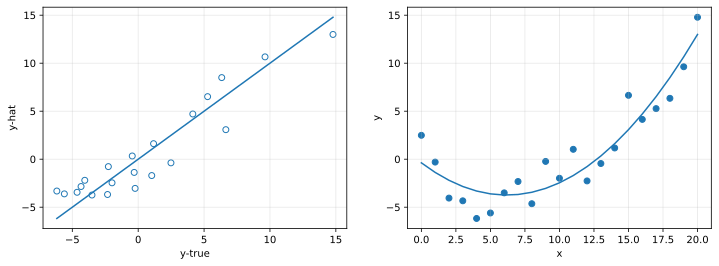

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

vmin, vmax = y.min(), y.max()
axs[0].plot([vmin, vmax], [vmin, vmax])
axs[0].scatter(y, yhat, color="none", edgecolor="tab:blue")
axs[0].set_ylabel("y-hat")
axs[0].set_xlabel('y-true')
axs[0].grid(alpha=0.3);

axs[1].plot(yhat)
axs[1].scatter(x, y)
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(alpha=0.3);